In [22]:
import requests
text = open('./sherlock-holmes.txt', 'r', encoding = 'utf-8').read()

In [23]:
import re
stop_pattern = '\.|\?|\!'
sentences = re.split(stop_pattern, text)
sentences = [re.sub("\r|\n", " ", s.lower()) for s in sentences]

In [24]:
import pandas as pd
has_sherlock = [True if re.search("sherlock|holmes", s) else False for s in sentences]
has_watson = [True if re.search("john|watson", s) else False for s in sentences]
df = pd.DataFrame({'text': sentences, 'has_sherlock': has_sherlock, 'has_watson': has_watson})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7309 entries, 0 to 7308
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   text          7309 non-null   object
 1   has_sherlock  7309 non-null   bool  
 2   has_watson    7309 non-null   bool  
dtypes: bool(2), object(1)
memory usage: 71.5+ KB


In [25]:
df.head()

,text,has_sherlock,has_watson
0,project gutenberg's the adventures of sherloc...,True,False
1,"you may copy it, give it away or re-use it u...",False,False
2,gutenberg,False,False
3,net title: the adventures of sherlock holmes...,True,False
4,a scandal in bohemia ii,False,False


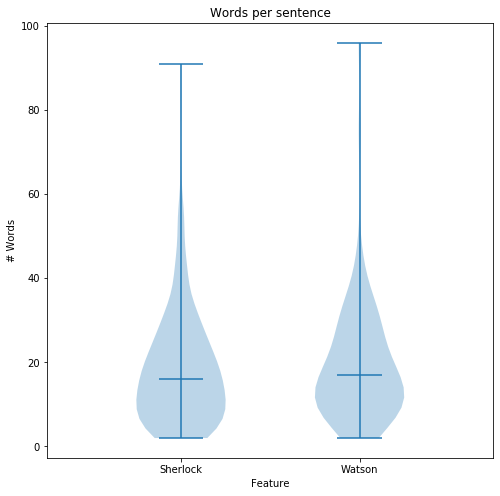

In [28]:
import os
import re
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## save the book locally
if not os.path.exists('sherlock-holmes.txt'):
    text = requests.get('https://www.gutenberg.org/files/1661/1661-0.txt').text
    with open("sherlock-holmes.txt", "w") as text_file:
        text_file.write(text)

## read in the book        
text = open('sherlock-holmes.txt', 'r', encoding = 'utf-8').read()

## do some basic parsing and cleaning of sentences
stop_pattern = '\.|\?|\!'
sentences = re.split(stop_pattern, text)
sentences = [re.sub("\r|\n"," ",s.lower()) for s in sentences][3:]

## extract a few features and create a pandas df
has_sherlock =  [True if re.search("sherlock|holmes",s) else False for s in sentences]
has_watson = [True if re.search("john|watson",s) else False for s in sentences]
df = pd.DataFrame({'text':sentences,'has_sherlock':has_sherlock,'has_watson':has_watson})
df['num_words'] = df['text'].apply(lambda x: len(x.split(" ")))

## make eda plot
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(111)

data1 = df[df['has_sherlock']==True]
data2 = df[df['has_watson']==True]

data = [df[df[col]==True]['num_words'].values for col in ['has_sherlock','has_watson']]

pos = [1,2]
ax1.violinplot(data, pos, points=40, widths=0.5,showextrema=True, showmedians=True)

labels = ['Sherlock', 'Watson']
ax1.set_xticks(np.arange(1, len(labels) + 1))
ax1.set_xticklabels(labels)
ax1.set_xlim(0.25, len(labels) + 0.75)
ax1.set_xlabel('Feature')
ax1.set_ylabel('# Words')
ax1.set_title("Words per sentence")

plt.show()

In [30]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline

labels = np.zeros(df.shape[0])
labels[(df['has_sherlock'] == True)] = 1
labels[(df['has_watson'] == True)] = 2
df['labels'] = labels
df = df[df['labels'] != 0]
x = df['text'].values
y = df['labels'].values

In [35]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.33, random_state = 42)

text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(loss = 'hinge', penalty = 'l2',
                         alpha = 1e-3, random_state = 42,
                         max_iter = 5, tol = None))
])

text_clf.fit(x_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=Non...
                ('clf',
                 SGDClassifier(alpha=0.001, average=False, class_weight=None,
                               early_stopping=False, epsilon=0.1, eta0=0.0,
                               fit_intercept=True, l1_ratio=0.15,
                               learning_rate='optimal', loss='hinge',
                      

In [36]:
from sklearn import metrics

predicted = text_clf.predict(x_test)

print(metrics.classification_report(y_test, predicted, target_names = ['sherlock', 'watson']))

              precision    recall  f1-score   support

    sherlock       1.00      1.00      1.00       155
      watson       1.00      1.00      1.00        31

    accuracy                           1.00       186
   macro avg       1.00      1.00      1.00       186
weighted avg       1.00      1.00      1.00       186

